<a href="https://colab.research.google.com/github/francji1/01NAEX/blob/main/code/01NAEX_exercise_02_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 01NAEX - Exercise 02 (Python)
This notebook combines the lecture example (originally prepared in Python) with the student assignment that was previously distributed as an R notebook. The goal is to keep all analysis and exercises in one Python environment.



## Lecture Example - Plasma Etch Rate Experiment
The lecture example investigates how the plasma etch rate responds to the radio-frequency (RF) power setting and to potential run-to-run variation. We will:
- explore and visualise the raw data,
- fit ANOVA models with and without the run factor,
- inspect model diagnostics,
- perform multiple comparisons (Tukey HSD and Fisher's LSD), and
- evaluate design power for several sample sizes.


In [19]:
# Core scientific Python stack for the example
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.power import FTestAnovaPower
from statsmodels.graphics.gofplots import qqplot

sns.set_theme(style="whitegrid")
np.set_printoptions(suppress=True)


In [20]:
# Load the plasma etch rate data used in the lecture example
ETCH_URL = "https://raw.githubusercontent.com/francji1/01NAEX/refs/heads/main/data/etchrate.txt"
etch_rate = pd.read_csv(ETCH_URL, delim_whitespace=True)

# Create categorical views that will be useful for the formulas
etch_rate = etch_rate.assign(
    Power=etch_rate["RF"].astype("category"),
    Run=etch_rate["run"].astype("category")
)

print("Rows, columns:", etch_rate.shape)
display(etch_rate.head())
etch_rate.describe(include="all")


Rows, columns: (20, 5)


/tmp/ipython-input-1323730227.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  etch_rate = pd.read_csv(ETCH_URL, delim_whitespace=True)


,RF,run,rate,Power,Run
0,160,1,575,160,1
1,160,2,542,160,2
2,160,3,530,160,3
3,160,4,539,160,4
4,160,5,570,160,5


,RF,run,rate,Power,Run
count,20.000000,20.000000,20.000000,20.0,20.0
unique,NaN,NaN,NaN,4.0,5.0
top,NaN,NaN,NaN,160.0,1.0
freq,NaN,NaN,NaN,5.0,4.0
mean,190.000000,3.000000,617.750000,NaN,NaN
std,22.941573,1.450953,61.648302,NaN,NaN
min,160.000000,1.000000,530.000000,NaN,NaN
25%,175.000000,2.000000,573.750000,NaN,NaN
50%,190.000000,3.000000,605.000000,NaN,NaN
75%,205.000000,4.000000,659.500000,NaN,NaN


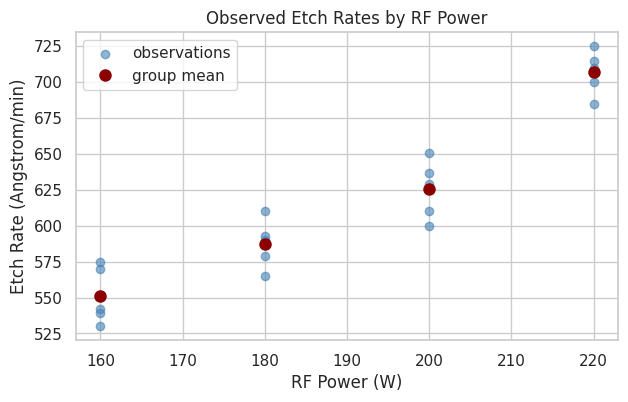

In [21]:
# Visual summary: scatter of observed rates with group means highlighted
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(etch_rate["RF"], etch_rate["rate"], color="steelblue", alpha=0.6, label="observations")
(
    etch_rate.groupby("RF")["rate"].mean()
    .plot(marker="o", color="darkred", linewidth=0, markersize=8, label="group mean", ax=ax)
)
ax.set_xlabel("RF Power (W)")
ax.set_ylabel("Etch Rate (Angstrom/min)")
ax.set_title("Observed Etch Rates by RF Power")
ax.legend()
plt.show()


/tmp/ipython-input-148346217.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=etch_rate, x="Power", y="rate", ax=axes[0], palette="Blues")
/tmp/ipython-input-148346217.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=etch_rate, x="Run", y="rate", ax=axes[1], palette="Greens")


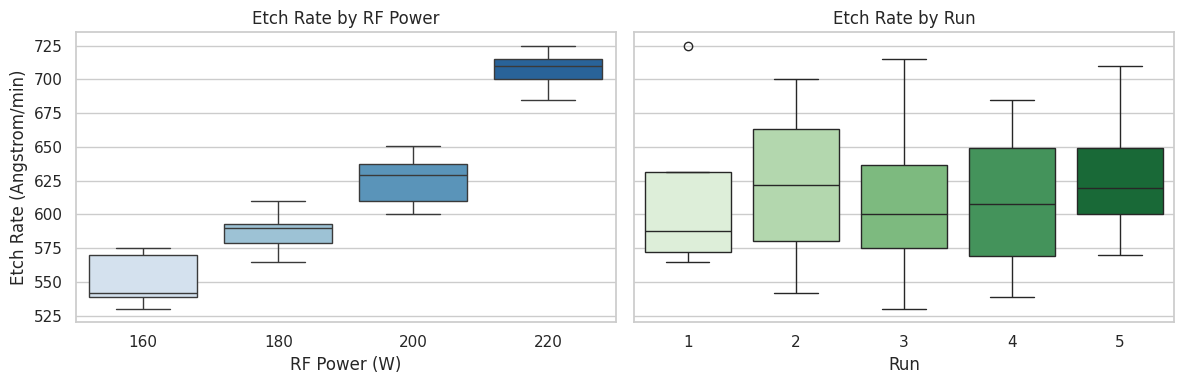

In [22]:
# Boxplots by RF power and by run to replicate the lecture visuals
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.boxplot(data=etch_rate, x="Power", y="rate", ax=axes[0], palette="Blues")
axes[0].set_title("Etch Rate by RF Power")
axes[0].set_xlabel("RF Power (W)")
axes[0].set_ylabel("Etch Rate (Angstrom/min)")

sns.boxplot(data=etch_rate, x="Run", y="rate", ax=axes[1], palette="Greens")
axes[1].set_title("Etch Rate by Run")
axes[1].set_xlabel("Run")

plt.tight_layout()
plt.show()


In [23]:
# Fit single-factor and two-factor ANOVA models used in the lecture
model_power = ols("rate ~ C(Power)", data=etch_rate).fit()
model_power_no_intercept = ols("rate ~ C(Power) - 1", data=etch_rate).fit()
model_power_run = ols("rate ~ C(Power) + C(Run)", data=etch_rate).fit()

print(model_power.summary())


                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     66.80
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           2.88e-09
Time:                        07:57:08   Log-Likelihood:                -84.250
No. Observations:                  20   AIC:                             176.5
Df Residuals:                      16   BIC:                             180.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         551.2000      8.169     

In [24]:
# ANOVA tables (type II sums of squares) for both models
anova_power = sm.stats.anova_lm(model_power, typ=2)
anova_power_run = sm.stats.anova_lm(model_power_run, typ=2)

display(anova_power)
display(anova_power_run)

# Direct comparison of the nested models (Power-only vs Power + Run)
display(sm.stats.anova_lm(model_power, model_power_run))


,sum_sq,df,F,PR(>F)
C(Power),66870.55,3.0,66.797073,2.882866e-09
Residual,5339.20,16.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(Power),66870.55,3.0,62.369063,1.368674e-07
C(Run),1050.50,4.0,0.734838,5.856737e-01
Residual,4288.70,12.0,NaN,NaN


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,16.0,5339.2,0.0,NaN,NaN,NaN
1,12.0,4288.7,4.0,1050.5,0.734838,0.585674


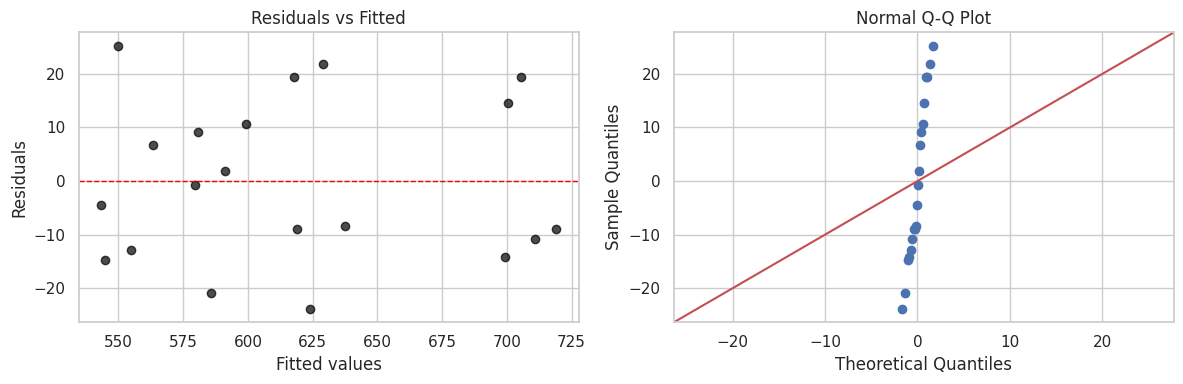

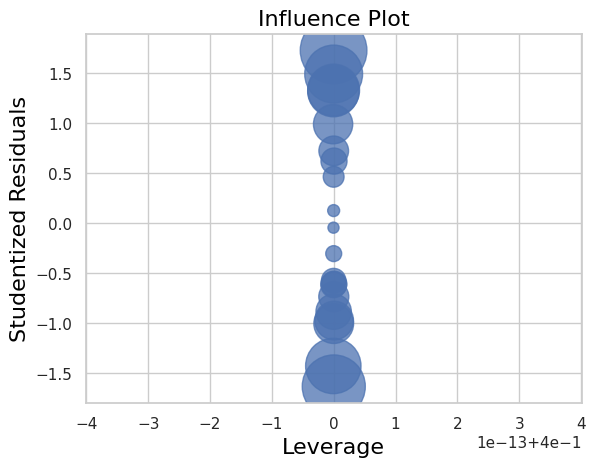

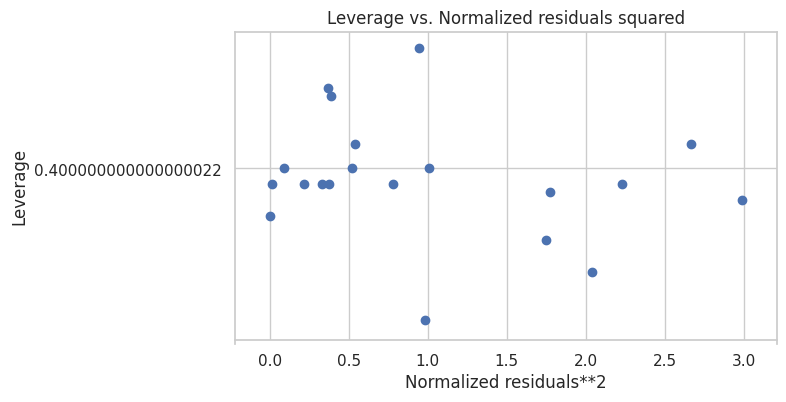

In [25]:
# Regression diagnostics mirroring the lecture content
residuals = model_power_run.resid
fitted = model_power_run.fittedvalues

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(fitted, residuals, color="black", alpha=0.7)
axes[0].axhline(0, color="red", linestyle="--", linewidth=1)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted")

qqplot(residuals, line="45", ax=axes[1])
axes[1].set_title("Normal Q-Q Plot")

plt.tight_layout()
plt.show()

influence = OLSInfluence(model_power_run)
fig = influence.plot_influence(figsize=(8, 6))
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))
sm.graphics.plot_leverage_resid2(model_power_run, ax=ax)
plt.show()


In [26]:
# Formal tests from the lecture (homogeneity, autocorrelation, etc.)
s_w, s_p = stats.shapiro(residuals)
levene_stat, levene_p = stats.levene(
    *[group["rate"].values for _, group in etch_rate.groupby("Power", observed=True)]
)
bartlett_stat, bartlett_p = stats.bartlett(
    *[group["rate"].values for _, group in etch_rate.groupby("Power", observed=True)]
)

bp_stat, bp_p, _, _ = het_breuschpagan(residuals, model_power_run.model.exog)
dw_stat = sm.stats.durbin_watson(residuals)

print(f"Shapiro-Wilk p-value: {s_p:.3f}")
print(f"Levene p-value:      {levene_p:.3f}")
print(f"Bartlett p-value:    {bartlett_p:.3f}")
print(f"Breusch-Pagan p:     {bp_p:.3f}")
print(f"Durbin-Watson stat:  {dw_stat:.3f}")


Shapiro-Wilk p-value: 0.317
Levene p-value:      0.898
Bartlett p-value:    0.443
Breusch-Pagan p:     0.038
Durbin-Watson stat:  2.854


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
   160    180     36.2 0.0294   3.1456  69.2544   True
   160    200     74.2    0.0  41.1456 107.2544   True
   160    220    155.8    0.0 122.7456 188.8544   True
   180    200     38.0 0.0216   4.9456  71.0544   True
   180    220    119.6    0.0  86.5456 152.6544   True
   200    220     81.6    0.0  48.5456 114.6544   True
------------------------------------------------------


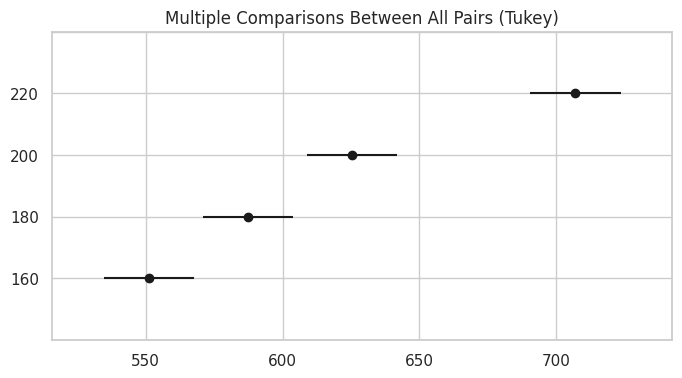

In [27]:
# Tukey HSD multiple comparisons (as demonstrated in the lecture)
tukey = pairwise_tukeyhsd(endog=etch_rate["rate"], groups=etch_rate["Power"], alpha=0.05)
print(tukey)
fig = tukey.plot_simultaneous(figsize=(8, 4))
plt.show()


In [28]:
# Fisher's LSD implementation with a compact letter display for quick interpretation
means = etch_rate.groupby("Power", observed=True)["rate"].mean()
counts = etch_rate.groupby("Power", observed=True)["rate"].count()
mse = anova_power_run.loc["Residual", "sum_sq"] / anova_power_run.loc["Residual", "df"]
df_error = anova_power_run.loc["Residual", "df"]

alpha = 0.05
t_crit = stats.t.ppf(1 - alpha / 2, df_error)
lsd = t_crit * np.sqrt(2 * mse / counts.mean())

print(f"Least Significant Difference (alpha={alpha}): {lsd:.2f}")
print("Group means (Angstrom/min):")
print(means.sort_index())

labels = {level: "" for level in means.index}
sorted_levels = means.sort_values(ascending=False).index

current_letter = ord("A")
for level in sorted_levels:
   if not labels[level]:
       labels[level] = chr(current_letter)
   for lower in sorted_levels[::-1]:
        if lower == level:
            continue
        diff = abs(means[level] - means[lower])
        if diff <= lsd:
            labels[lower] = labels[level]
        current_letter += 1

print("Compact letter display (shared letters indicate no significant difference):")
for level in sorted_levels:
        print(f"Power {level}: mean={means[level]:.1f}, label={labels[level]}")


Least Significant Difference (alpha=0.05): 26.05
Group means (Angstrom/min):
Power
160    551.2
180    587.4
200    625.4
220    707.0
Name: rate, dtype: float64
Compact letter display (shared letters indicate no significant difference):
Power 220: mean=707.0, label=A
Power 200: mean=625.4, label=D
Power 180: mean=587.4, label=G
Power 160: mean=551.2, label=J


,n per group,power
0,4,0.938481
1,5,0.991788
2,6,0.999172
3,7,0.999932
4,8,0.999995
5,9,1.000000
6,10,1.000000


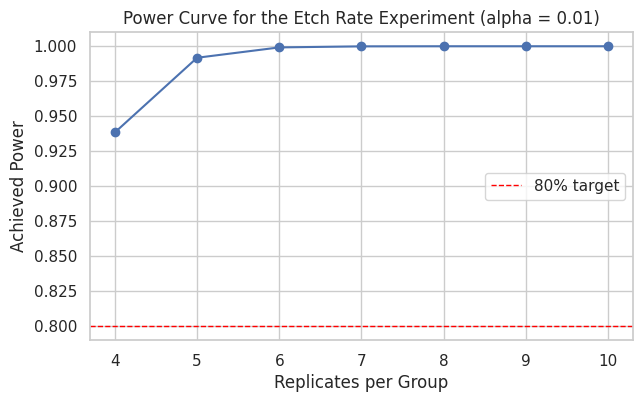

In [29]:
# Power exploration mirroring the lecture discussion
power_analysis = FTestAnovaPower()
alpha = 0.01
sigma = 25
max_diff = 75

cohen_f = (max_diff / 2) / sigma

sample_sizes = np.arange(4, 11)
power_values = [power_analysis.power(effect_size=cohen_f, nobs=n * 4, alpha=alpha, k_groups=4)
                for n in sample_sizes]

power_df = pd.DataFrame({"n per group": sample_sizes, "power": power_values})
display(power_df)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(sample_sizes, power_values, marker="o")
ax.set_xlabel("Replicates per Group")
ax.set_ylabel("Achieved Power")
ax.set_title("Power Curve for the Etch Rate Experiment (alpha = 0.01)")
ax.axhline(0.8, color="red", linestyle="--", linewidth=1, label="80% target")
ax.legend()
plt.show()



## Student Assignment - Chapter 3 Exercises
Use the following cells to work through the problems. Each question mirrors the wording from the textbook; add your analysis in the empty code cells provided.



### Exercise 3.07 - Portland Cement Tensile Strength
Four mixing techniques are compared using a completely randomised design; tensile strength (lb/in^2) is recorded for four replicates at each technique.


In [30]:
# Data for Exercise 3.07
ex03_7 = pd.read_csv(
    "https://raw.githubusercontent.com/francji1/01NAEX/main/data/Ex03_7.csv",
    sep=";"
)
ex03_7 = ex03_7.assign(Technique=ex03_7["Technique"].astype("category"))
cement = ex03_7.rename(columns={"Tensile_Strength": "strength"})
cement.head()


,Technique,strength
0,1,3129
1,1,3000
2,1,2865
3,1,2890
4,2,3200


**Question 1.** Construct graphical displays that compare the mean tensile strengths for the four mixing techniques.

In [31]:
# TODO: add your analysis here

**Question 2.** Test at alpha = 0.05 whether mixing technique affects tensile strength.

In [32]:
# TODO: add your analysis here

**Question 3.** Use Fisher's LSD method with alpha = 0.05 to make pairwise comparisons between techniques.

In [33]:
# TODO: add your analysis here

**Question 4.** Construct a normal probability plot of the residuals. Does the normality assumption appear reasonable?

In [34]:
# TODO: add your analysis here

**Question 5.** Plot the residuals versus the fitted tensile strength and comment.

In [35]:
# TODO: add your analysis here

**Question 6.** Prepare a scatter plot of the raw observations to aid interpretation.

In [36]:
# TODO: add your analysis here


### Exercises 3.08 and 3.09 - Follow-Up Comparisons
We revisit the Portland cement experiment to explore multiple comparisons and confidence intervals.


**Question 1.** Rework the pairwise comparisons using Tukey's test with alpha = 0.05. Do the conclusions match the graphical procedure and Fisher's LSD?

In [37]:
# TODO: add your analysis here


**Question 2.** Explain the difference between Tukey's procedure and Fisher's LSD.


*Write your explanation here.*

**Question 3.** Find 95 percent confidence intervals for each technique mean and for the difference between techniques 1 and 3. How do these intervals aid interpretation?

In [38]:
# TODO: add your analysis here


### Exercise 3.10 - Cotton Content Experiment
Synthetic fibre tensile strength is measured at five cotton-content levels with five replicates each.


In [39]:
# Data for Exercise 3.10
ex03_10 = pd.read_csv(
    "https://raw.githubusercontent.com/francji1/01NAEX/main/data/Ex03_10.csv",
    sep=";"
).rename(columns={"Cotton_Weight ": "Cotton_Weight", "Observations": "strength"})
ex03_10 = ex03_10.assign(Cotton_Weight=ex03_10["Cotton_Weight"].astype("category"))
ex03_10.head()


,Cotton_Weight,strength
0,15,7
1,20,12
2,25,14
3,30,19
4,35,7


**Question 1.** Test at alpha = 0.05 whether cotton content affects mean fibre strength.

In [40]:
# TODO: add your analysis here

**Question 2.** Use Fisher's LSD (alpha = 0.05) to compare the mean strengths across cotton levels.

In [41]:
# TODO: add your analysis here

**Question 3.** Analyse residuals and comment on model adequacy.

In [42]:
# TODO: add your analysis here

### Exercise 3.18 and 3.19

A manufacturer of television sets is interested in the effect on tube conductivity of four different types of coating for color picture tubes.  
A completely randomized experiment is conducted and the following conductivity data are obtained:

| Coating Type | Conductivity              |
|--------------|---------------------------|
| 1            | 143, 141, 150, 146        |
| 2            | 152, 149, 137, 143        |
| 3            | 134, 136, 132, 127        |
| 4            | 129, 127, 132, 129        |

**Question 1.**  Is there a difference in conductivity due to coating type? Use α = 0.05.  

**Question 2.**  Estimate the overall mean and the treatment effects.  

**Question 3.** Compute a 95 percent confidence interval estimate of the mean of coating type 4.  
Compute a 99 percent confidence interval estimate of the mean difference between coating types 1 and 4.  

**Question 4.**  Test all pairs of means using the Fisher LSD method with α = 0.05.  

**Question 5.**  Use the graphical method discussed in Section 3.5.3 to compare the means. Which coating type produces the highest conductivity?  

**Question 6.**  Assuming that coating type 4 is currently in use, what are your recommendations to the manufacturer?  
We wish to minimize conductivity.  

**Question 7.**  
Analyze the residuals and draw conclusions about model adequacy.

In [43]:
# TODO: recreate the coating_data DataFrame for Exercise 3.18

**Question 1.** Is there a difference in conductivity due to coating type? Use alpha = 0.05.

In [44]:
# TODO: fit the ANOVA model and report the F-statistic and p-value

**Question 2.** Estimate the overall mean and the treatment effects.

In [45]:
# TODO: compute the grand mean and treatment effects

**Question 3.** Compute a 95% confidence interval for the mean of coating type 4 and a 99% confidence interval for the mean difference between coatings 1 and 4.

In [46]:
# TODO: calculate the requested confidence intervals

**Question 4.** Test all pairs of means using the Fisher LSD method with alpha = 0.05.

In [47]:
# TODO: compute Fisher's LSD and summarise significant comparisons

**Question 5.** Use the graphical method from Section 3.5.3 to compare the means. Which coating type produces the highest conductivity?

In [48]:
# TODO: create the plot of means with LSD intervals

**Question 6.** Assuming coating type 4 is currently in use and conductivity should be minimised, what is your recommendation?

*Write your recommendation here.*

**Question 7.** Analyse the residuals and comment on model adequacy.

In [49]:
# TODO: produce residual plots and formal tests